In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from copy import deepcopy
import argparse
import sys
import traceback
import json
from tqdm import tqdm_notebook, tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from utils import *


parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.seed = 123
args.nbits = 2048
args.n_splits = 5
args.test_size = 0.2
args.num_mol = 50000
args.max_len = 120
args.shuffle = True
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
args.optim = 'RMSProp'

np.random.seed(args.seed)
torch.manual_seed(args.seed)

# 1. Prepare Dataset

In [3]:
list_partition = make_partition(args)

# 2. Model Architecture

Create char_to_ix Ref: https://github.com/pytorch/tutorials/blob/master/beginner_source/nlp/word_embeddings_tutorial.py  
Pre-defined Embedding Layer Ref: https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76  
ResNet Variation Ref: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

In [4]:
def create_vocab(filename='../Data/logP/vocab.npy'):
    vocab = np.load(filename)
    vocab_size = len(vocab)
    char_to_ix = {char: i for i, char in enumerate(vocab)}
    return vocab, char_to_ix

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_filter, out_filter, stride, use_bn, dp_rate, block_type):
        super(ResBlock, self).__init__()   
        self.use_bn = use_bn
        self.block_type = block_type
        self.conv1 = nn.Conv2d(in_filter, out_filter, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_filter, out_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_filter)
        self.bn2 = nn.BatchNorm2d(out_filter)
        self.dropout = nn.Dropout2d(dp_rate)
        self.shortcut = nn.Sequential()
        if in_filter != out_filter:
            self.shortcut.add_module(
                'conv', nn.Conv2d(in_filter, out_filter,
                                  kernel_size=1, stride=stride, 
                                  padding=0, bias=False)
            )
        
    def forward(self, _x):
        if self.block_type == 'a': #original residual block
            x = self.relu(self.bn1(self.conv1(_x))) if self.use_bn else self.relu(self.conv1(_x))
            x = self.bn2(self.conv2(x)) if self.use_bn else self.conv2(x)
            x = x + self.shortcut(_x)
            return self.dropout(self.relu(x))
        
        elif self.block_type == 'b': # BN after addition
            x = self.relu(self.bn1(self.conv1(_x))) if self.use_bn else self.relu(self.conv1(_x))
            x = self.conv2(x) + self.shortcut(_x)
            return self.dropout(self.relu(self.bn2(x)) if self.use_bn else self.relu(x))
        
        elif self.block_type == 'c': # ReLU before addition
            x = self.relu(self.bn1(self.conv1(_x))) if self.use_bn else self.relu(self.conv1(_x))
            x = self.relu(self.bn2(self.conv2(x))) if self.use_bn else self.relu(self.conv2(x))
            return self.dropout(x + self.shortcut(_x))
        
        elif self.block_type == 'd': # ReLU-only pre-activation
            x = self.bn1(self.conv1(self.relu(_x))) if self.use_bn else self.conv1(self.relu(_x))
            x = self.bn2(self.conv2(self.relu(x))) if self.use_bn else self.conv2(self.relu(x))
            return self.dropout(x + self.shortcut(_x))
        
        elif self.block_type == 'e': # full pre-activation
            x = self.conv1(self.relu(self.bn1(_x))) if self.use_bn else self.conv1(self.relu(_x))
            x = self.conv2(self.relu(self.bn2(x))) if self.use_bn else self.conv2(self.relu(x))
            return self.dropout(x + self.shortcut(_x))
             
            

class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()   
        
        # Create Atom Element embedding layer
        self.embedding = self.create_emb_layer(args.vocab_size, args.emb_train)
        
        # Create Residual Convolution layer
        list_res_blocks = list()
        n_channel = 1
        for i in range(args.n_stage):
            if i==0:
                list_res_blocks.append(ResBlock(n_channel, n_channel*args.start_channel, args.stride, args.use_bn, args.dp_rate, args.block_type))
                n_channel *= args.start_channel
            else:
                list_res_blocks.append(ResBlock(n_channel, n_channel*2, args.stride, args.use_bn, args.dp_rate, args.block_type))
                n_channel *= 2
            for j in range(args.n_layer-1):
                list_res_blocks.append(ResBlock(n_channel, n_channel, 1, args.use_bn, args.dp_rate, args.block_type))
        self.res_blocks = nn.Sequential(*list_res_blocks)
        
        # Create MLP layers
        fc_shape = self._estimate_fc_shape((1, args.max_len,))
#         fc_shape = (4000, 200)
        self.fc1 = nn.Linear(fc_shape[-1], 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self._conv_forward(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(x)
    
    def _conv_forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(embeds.shape[0], 1, embeds.shape[1], embeds.shape[2])
        x = self.res_blocks(embeds)
        return x
    
    def _estimate_fc_shape(self, input_shape):
        dummy_input = torch.zeros(input_shape).long()
        dummy_output = self._conv_forward(dummy_input)
        fc_shape = dummy_output.view(dummy_output.shape[0], -1).shape
        return fc_shape
        

    def create_emb_layer(self, vocab_size, emb_train):
        emb_layer = nn.Embedding(vocab_size, vocab_size)
        weight_matrix = torch.zeros((vocab_size, vocab_size))
        for i in range(vocab_size):
            weight_matrix[i][i] = 1
        emb_layer.load_state_dict({'weight': weight_matrix})

        if not emb_train:
            emb_layer.weight.requires_grad = False
        return emb_layer

# 3. Train, Validate, Evaluate

In [6]:
def train(model, partition, optimizer, criterion, char_to_ix, args, **kwargs):
    data_iter = DataLoader(
        partition['train'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        X, y = batch[0], batch[1]
        X = torch.Tensor([[char_to_ix[c] for c in smile] for smile in X]).long()
        X, y = X.to(args.device), y.to(args.device).float()
    
        model.train()
        optimizer.zero_grad()

        pred_y = model(X)
        pred_y.require_grad = False
        train_loss = criterion(pred_y, y)
        epoch_train_loss += train_loss.item()
        list_train_loss.append({'epoch':batch_idx/len(data_iter)+kwargs['epoch'], 'train_loss':train_loss.item()})
        train_loss.backward()
        optimizer.step()
        
        cnt_iter += 1
        args.bar.update(len(X))
#         break
    return model, list_train_loss

def validate(model, partition, criterion, char_to_ix, args):
    data_iter = DataLoader(
        partition['val'],
        batch_size=args.test_batch_size,
        shuffle=args.shuffle
    )
    
    epoch_val_loss = 0
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        X, y = batch[0], batch[1]
        X = torch.Tensor([[char_to_ix[c] for c in smile] for smile in X]).long()
        X, y = X.to(args.device), y.to(args.device).float()
    
        model.eval()
        pred_y = model(X)
        pred_y.require_grad = False
        val_loss = criterion(pred_y, y)
        epoch_val_loss += val_loss.item()
        cnt_iter += 1

    return epoch_val_loss/cnt_iter

def test(model, partition, char_to_ix, args, **kwargs):
    data_iter = DataLoader(
        partition['test'],
        batch_size=args.test_batch_size,
        shuffle=False
    )
    
    list_y, list_pred_y = list(), list()
    for batch_idx, batch in enumerate(data_iter):
        X, y = batch[0], batch[1]
        X = torch.Tensor([[char_to_ix[c] for c in smile] for smile in X]).long()
        X, y = X.to(args.device), y.to(args.device).float()
    
        model.eval()
        pred_y = model(X)
        list_y += y.cpu().detach().numpy().tolist()
        list_pred_y += pred_y.cpu().detach().numpy().tolist()
        args.bar.update(len(X))

    mae = mean_absolute_error(list_y, list_pred_y)
    std = np.std(np.array(list_y)-np.array(list_pred_y))
    return mae, std, list_y, list_pred_y

def experiment(partition, args):
    ts = time.time()
    vocab, char_to_ix = create_vocab()
    args.vocab_size = len(vocab)
    args.input_shape = (args.max_len, args.vocab_size)
    model = Net(args)
    model.to(args.device)
    criterion = nn.MSELoss()
    
    # Initialize Optimizer
    trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_mae = list()
    list_std = list()
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        model, train_losses = train(model, partition, optimizer, criterion, char_to_ix, args, **{'bar':bar, 'epoch':epoch})
        val_loss = validate(model, partition, criterion, char_to_ix, args)
        mae, std, true_y, pred_y = test(model, partition, char_to_ix, args, **{'bar':bar, 'epoch':epoch})

        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_mae.append({'epoch':epoch, 'mae':mae})
        list_std.append({'epoch':epoch, 'std':std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            args.best_true_y = true_y
            args.best_pred_y = pred_y
    
    te = time.time()
    
    # Logging Experiment Results
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.maes = list_mae
    args.stds = list_std
    return args

# Experiment.1  

In [11]:
exp_name = 'exp1_layer_stage'
args.exp_name = 'exp1_layer_stage'
args.n_layer = 2
args.n_stage = 1
args.lr = 0.00005
args.l2_coef = 0.0001
args.optim = 'ADAM'
args.epoch = 20
args.batch_size= 256
args.test_batch_size= 256
args.emb_train = False
args.start_channel = 8
args.stride = 2
args.use_bn = True
args.dp_rate = 0.3
args.block_type = 'a'
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage','block_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'batch_size'])
partition = list_partition[0]

# Define Hyperparameter Search Space
list_n_layer = [1,2,3,4]
list_n_stage = [1,2,3,4]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_n_layer)*len(list_n_stage)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

writer.clear(exp_name)
for n_layer in list_n_layer:
    for n_stage in list_n_stage:
        # Update hyperparameter
        args.n_layer = n_layer
        args.n_stage = n_stage
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2}'.format(cnt_exp, result.best_mae, result.best_std, result.epoch))


[Exp  1] got mae: 0.466, std: 0.523 at epoch 20
[Exp  2] got mae: 0.550, std: 0.569 at epoch 20
[Exp  3] got mae: 0.432, std: 0.532 at epoch 20
[Exp  4] got mae: 0.410, std: 0.505 at epoch 20
[Exp  5] got mae: 0.613, std: 0.693 at epoch 20
[Exp  6] got mae: 0.578, std: 0.699 at epoch 20
[Exp  7] got mae: 0.465, std: 0.563 at epoch 20
[Exp  8] got mae: 0.430, std: 0.541 at epoch 20
[Exp  9] got mae: 0.614, std: 0.703 at epoch 20
[Exp 10] got mae: 0.545, std: 0.650 at epoch 20
[Exp 11] got mae: 0.535, std: 0.679 at epoch 20
[Exp 12] got mae: 0.553, std: 0.698 at epoch 20
[Exp 13] got mae: 0.715, std: 0.791 at epoch 20
[Exp 14] got mae: 0.653, std: 0.831 at epoch 20
[Exp 15] got mae: 0.565, std: 0.716 at epoch 20
[Exp 16] got mae: 0.695, std: 0.805 at epoch 20


In [16]:
results = writer.read(exp_name='exp1_layer_stage')

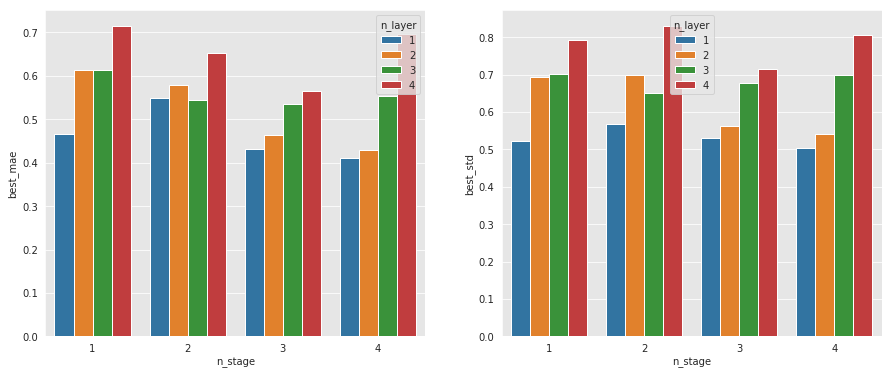

In [24]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.barplot(x='n_stage', y='best_mae', hue='n_layer', data=results, ax=ax[0])

sns.barplot(x='n_stage', y='best_std', hue='n_layer', data=results, ax=ax[1])



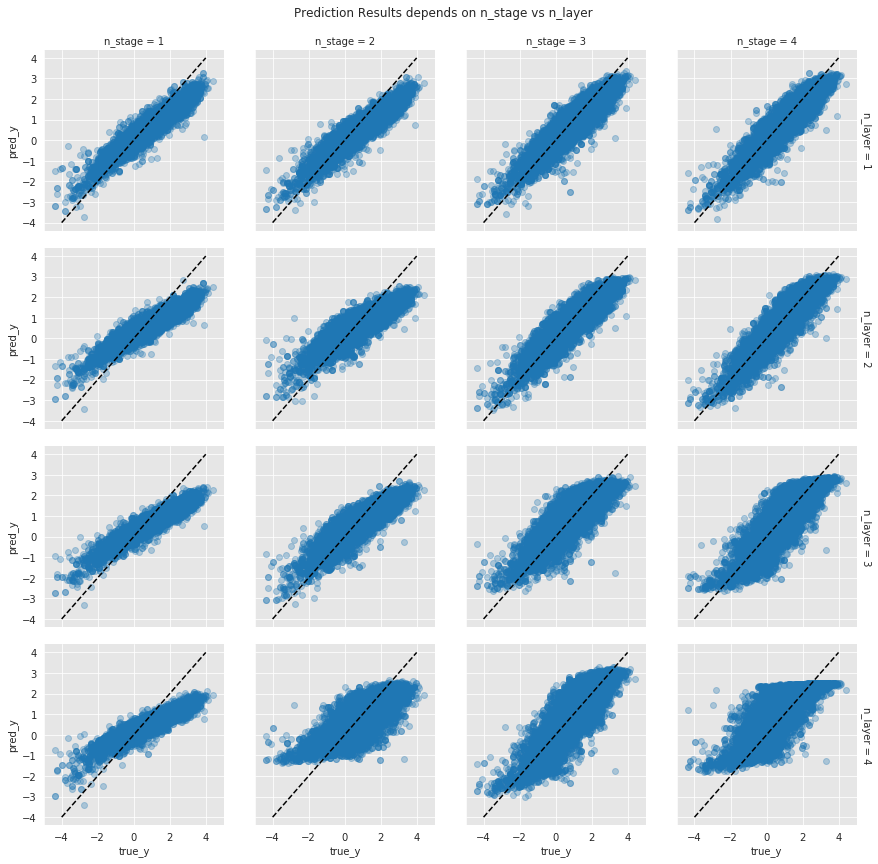

In [54]:
variable1 = 'n_stage'
variable2 = 'n_layer'
x = 'true_y'
y = 'pred_y'

def plot_distribution(variable1, variable2, x='true_y', y='pred_y', title='', filename=''):
    list_v1 = results[variable1].unique()
    list_v2 = results[variable2].unique()
    list_data = list()
    for value1 in list_v1:
        for value2 in list_v2:
            row = results.loc[results[variable1]==value1]
            row = row.loc[results[variable2]==value2]

            best_true_y = list(row.best_true_y)[0]
            best_pred_y = list(row.best_pred_y)[0]
            for i in range(len(best_true_y)):
                list_data.append({x:best_true_y[i], y:best_pred_y[i], variable1:value1, variable2:value2})
    df = pd.DataFrame(list_data)

    g = sns.FacetGrid(df, row=variable2, col=variable1, margin_titles=True)
    g.map(plt.scatter, x, y, alpha=0.3)

    def identity(**kwargs):
        plt.plot(np.linspace(-4,4,50), np.linspace(-4,4,50),'k',linestyle='dashed')
    g.map(identity)
    g.set_axis_labels(x, y)
    g.fig.suptitle(title) # can also get the figure from plt.gcf()
    plt.subplots_adjust(top=0.93)
    filename = filename if len(filename) > 0 else title
    plt.savefig('./images/{}.png'.format(filename))

plot_distribution(variable1, variable2, x, y, 'Prediction Results depends on n_stage vs n_layer')

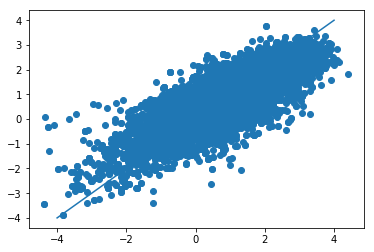

In [9]:
true_y = results['best_true_y'][0]
pred_y = results['best_pred_y'][0]
plt.scatter(true_y, pred_y)
plt.plot(np.linspace(-4,4,100), np.linspace(-4,4,100))

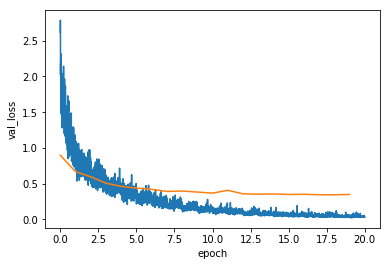

In [10]:
train_loss = pd.DataFrame(results['train_losses'][0])
val_loss = pd.DataFrame(results['val_losses'][0])
grid = sns.lineplot(data=train_loss, x='epoch', y='train_loss')
grid = sns.lineplot(data=val_loss, x='epoch', y='val_loss')

In [ ]:
grid = sns.FacetGrid(results, row='n_stage', col='n_layer', margin_titles=True)
grid.map(plt.scatter, x='best_true_y', y='best_pred_y')